In [300]:
import pandas as pd
import numpy as np
import os
import traceback
np.seterr(all="ignore")
#--- user libs
import utility as utl
import imp
imp.reload(utl)

<module 'utility' from '/Users/Home/Desktop/Tmp/txt/git/DislocationAvalanches/nanoindentation/avalancheAnalysis/utility.py'>

# set parameters

In [322]:
path = '/Users/Home/Desktop/Tmp/txt/git/DislocationAvalanches/nanoindentation/loadCurves'
dirs = '0.75 mN'
inputFiles = os.listdir('%s/%s'%(path,dirs))
print('inputFiles=',np.array(inputFiles))




inputFiles= ['Stal_310S_virgin_0,75mN_15x 5 4694 -1918.txt'
 'Stal_310S_virgin_0,75mN_15x 13 4694 -1758.txt'
 'Stal_310S_virgin_0,75mN_15x 2 4694 -1978.txt'
 'Stal_310S_virgin_0,75mN_15x 14 4694 -1738.txt'
 'Stal_310S_virgin_0,75mN_15x 7 4694 -1878.txt'
 'Stal_310S_virgin_0,75mN_15x 11 4694 -1798.txt'
 'Stal_310S_virgin_0,75mN_15x 10 4694 -1818.txt'
 'Stal_310S_virgin_0,75mN_15x 6 4694 -1898.txt'
 'Stal_310S_virgin_0,75mN_15x 8 4694 -1858.txt'
 'Stal_310S_virgin_0,75mN_15x 15 4694 -1718.txt'
 'Stal_310S_virgin_0,75mN_15x 3 4694 -1958.txt'
 'Stal_310S_virgin_0,75mN_15x 9 4694 -1838.txt'
 'Stal_310S_virgin_0,75mN_15x 1 4694 -1998.txt'
 'Stal_310S_virgin_0,75mN_15x 12 4694 -1778.txt'
 'Stal_310S_virgin_0,75mN_15x 4 4694 -1938.txt']


# Parse load curves

In [323]:
#--- read input file
loadTimeSeries = list(map(lambda x:pd.read_csv('%s/%s/%s'%(path,dirs,x),
                 sep='\t',index_col=False,names=['Time','Depth','Force']),inputFiles))
#--- derivative
loadTimeSeries = list(map(lambda x:pd.DataFrame(np.c_[x,np.gradient(x.Depth,x.Time)],columns=['Time','Depth','Force','Rate']),loadTimeSeries))
loadTimeSeries[1] #--- index indicates the indenter location

,Time,Depth,Force,Rate
0,0.000000,-398.085584,-0.011937,inf
1,0.000000,-355.986086,-0.011021,NaN
2,0.000000,-316.912336,-0.010103,NaN
3,0.000000,-281.695627,-0.009182,NaN
4,0.000000,-246.597360,-0.008267,NaN
...,...,...,...,...
183,69.264726,78.221847,0.037772,-14.851913
184,69.313344,77.483080,0.025410,-8.217323
185,69.361720,77.421447,0.013277,-4.539163
186,69.412781,77.013699,0.001894,-2.252306


# Plot timeseries

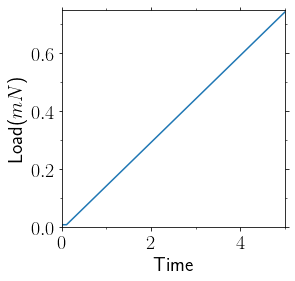

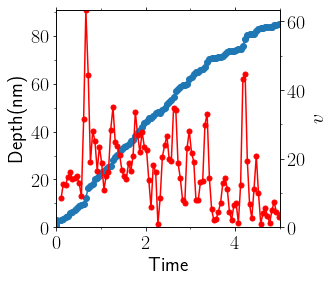

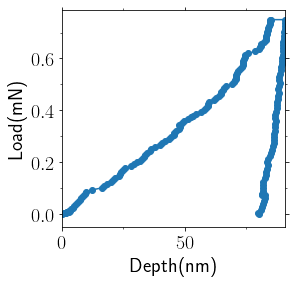

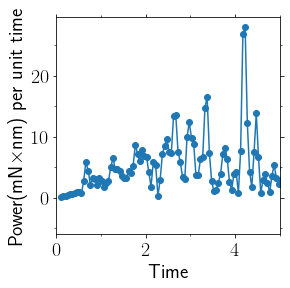

<AxesSubplot:xlabel='Time', ylabel='Power(mN$\\times$nm) per unit time'>

In [355]:
#--- set limits
ld = loadTimeSeries[ 3 ]

#--- time
tlo = 0
thi = 5 #ld.Time.max()
#--- load
flo = 0
fhi = ld.Force.max()
#--- depth
hlo = 0.0
hhi = ld.Depth.max()
#--- velocity
vlo = 0.0
vhi = ld.Rate[ld.Rate!=np.inf].max()

#--- load vs. time
utl.PltErr(ld.Time, ld.Force,
           attrs={'fmt':'-'},
           xlim=(tlo,thi),
           ylim=(flo,fhi),
           xstr=r'Time',
           ystr=r'Load($mN$)',
          )

#--- depth vs. time
ax = utl.PltErr(ld.Time, ld.Depth,
           xlim=(tlo,thi),
           ylim=(hlo,hhi),
           xstr=r'Time',
           ystr=r'Depth(nm)',
           Plot=False,
          )

#--- velocity vs. time
utl.PltErr(ld.Time, ld.Rate,
           xlim=(tlo,thi),
           ylim=(vlo,vhi),
#           xstr=r'Time',
           ystr=r'$v$',
           attrs={'fmt':'-r.','markersize':10},
           Plot = True,
           twinx = True,
           ax=ax,
#           yscale='log'
          )


#--- load vs. depth
utl.PltErr(ld.Depth, ld.Force,
           xlim=(hlo,hhi),
#            ylim=(0,0.4),
           xstr=r'Depth(nm)',
           ystr=r'Load(mN)',
          )

#--- power vs. time
utl.PltErr(ld.Time, ld.Force * ld.Rate,
           xlim=(tlo,thi),
#            ylim=(0,1),
           xstr=r'Time',
           ystr=r'Power(mN$\times$nm) per unit time',
          )

# Avalanche statistics

## Power distributions

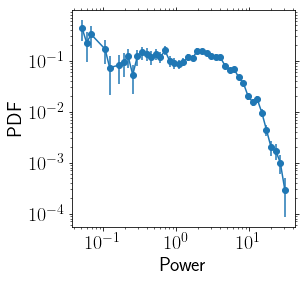

<AxesSubplot:xlabel='Power', ylabel='PDF'>

In [346]:
def GetPower(ld,tlo,thi):
    filtr = np.all([ld.Time>tlo,ld.Time<thi],axis=0)
    value = (ld.Force*ld.Rate)[filtr]
    return (value[ value > 0.0 ]).to_list()

value = np.concatenate(list(map(lambda x:GetPower(x,tlo,thi), loadTimeSeries)))
hist, edge, err = utl.GetPDF(value, n_per_decade=16, linscale=None)

utl.PltErr(edge, hist, yerr=err,
#           xlim=(tlo,thi),
#            ylim=(0,0.4),
           ystr=r'PDF',
           xstr=r'Power',
           xscale = 'log',
           yscale='log'
          )

## Avalanche size

In [358]:
def Wrapper(ld,tlo,thi,lambdc):
    '''
    return avalanche sizes given force timeseries and initial and final times
    '''
    
#    print(np.min(GetPower(ld,tlo,thi)))
    
    #--- data frame storing avalanche attributes
    filtr = np.all([ld.Time>tlo,ld.Time<thi],axis=0)

    df_avl = utl.GetAvl( np.array(ld.Time[filtr]), np.array(ld.Force*ld.Rate)[filtr], lambdc)
    #df_avl = GetAvalKunMethod( broken_bonds,  5) #tcrltn )

    #--- save
    # df_fltrd = DataFrameSubSet( df_avl, #--- filter
    #                               'ti', 
    #                               ( 0, tavl ) ) 
    # df_fltrd.to_pickle('df_avl.pk')

#    display( df_avl.sort_values( by = 'size',ascending = False) )
#    print ('n.avls = %s'%len(df_avl))
    return df_avl['size'].to_list()
    
lambdc = 0.4 #--- threshold
sizes = np.concatenate(list(map(lambda x:Wrapper(x,tlo,thi,lambdc), loadTimeSeries)))

### Plot

#### accumulated

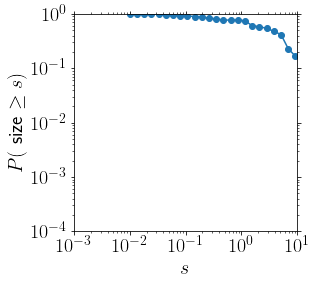

<AxesSubplot:xlabel='$s$', ylabel='$P($ size $\\ge s)$'>

In [359]:
hist, edge = utl.GetPDF(sizes, ACCUM = True, n_per_decade=8, linscale=None)

utl.PltErr(edge[:-1], 1-hist,
           xlim=(1e-3,1e1),
            ylim=(1e-4,1),
           ystr=r'$P($ size $\ge s)$',
           xstr=r'$s$',
           xscale = 'log',
           yscale='log'
          )

#### pdf

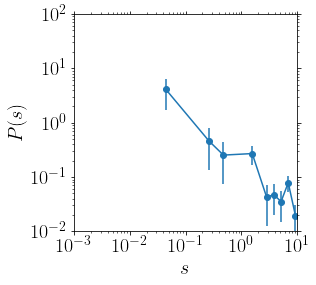

<AxesSubplot:xlabel='$s$', ylabel='$P(s)$'>

In [360]:
hist, edge, err = utl.GetPDF(sizes, n_per_decade=8, linscale=None)

utl.PltErr(edge, hist, yerr=err,
           xlim=(1e-3,1e1),
            ylim=(1e-2,1e2),
           ystr=r'$P(s)$',
           xstr=r'$s$',
           xscale = 'log',
           yscale='log'
          )

#### vary threshold

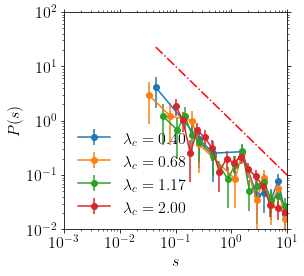

In [361]:
def varyThreshold(loadTimeSeries, tlo, thi, lambdc):
    return np.concatenate(list(map(lambda x:Wrapper(x,tlo,thi,lambdc), loadTimeSeries)))

lambdc = np.logspace(np.log10(4.0e-1),np.log10(2.0e0),4)
size_lambdc = list(map(lambda x:varyThreshold(loadTimeSeries, tlo, thi, x),lambdc))

#--- distributions
hists = list(map(lambda x: utl.GetPDF(x, n_per_decade=8, linscale=None), size_lambdc))


for item, threshold, indx in zip(hists, lambdc, range(len(hists))):
    hist, edge, err = item
    if indx == 0:
        ax = utl.PltErr(edge, hist, yerr=err,
                        Plot = False,
                        legend = True,
                        label=r'$\lambda_c=%3.2f$'%threshold,
                  )
        ax = utl.PltErr(edge, 1/edge**1.0,
                        Plot = False,
                        fmt = '-.r',
                        ax = ax,
#                        legend = True,
#                        label=r'$\lambda_c=%3.2f$'%threshold,
                  )
    else:
        ax = utl.PltErr(edge, hist, yerr=err,
                        xlim=(1e-3,1e1),
                       ylim=(1e-2,1e2),
                       ystr=r'$P(s)$',
                       xstr=r'$s$',
                       xscale = 'log',
                       yscale='log',
                       Plot = False,
                       ax=ax,
                       label=r'$\lambda_c=%3.2f$'%threshold,
                        legend = True,
                        loc=3,
                        fontsize=16,
                      )